<a href="https://colab.research.google.com/github/AguaClara/SWOT/blob/master/Unit_Process_Designs/CDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chemical Dose Controller
The goal is to define the distinct design strategies required as a function of flow rate for the chemical dose controller. There are expected to be 3 distinct design regions.

Chemical resistance is critical for the design of the components exposed to chlorine. According to [Chemical Resistance of Thermoplastics Piping Materials](https://plasticpipe.org/pdf/tr-19_thermoplastic_pipe_for_transport_of_chemical.pdf), the plastics that are compatible with bleach at 12% active $Cl_2$ at temperatures above 40 $^\circ C$ are:
*   CPVC (chlorinated polyvinyl chloride)
*   PVC (polyvinyl chloride)
*   PP (polypropylene)
*   PB (polybutylene)


Arrays of multiple tubes each with their own valve are difficult to maintain because each tube needs to be removed in turn to be cleaned. To reduce the time required for cleaning it is preferred that a complete set of tubes be removed together. Thus this design will always have two flow resistors of equal flow that are installed in parallel with only one active at a time. The plant should have a third flow resistor on hand as a spare that can be clean and ready to replace a defective unit at any time.




1.   single dosing tube of 1/8" ID where the stock solution is varied to obtain a range of maximum chemical mass rates. A spare tube is plumbed and the active tube is selected by valves.
2.   set of multiple tubes connected via a manifold with one valve at each end for the entire set.
3.   Pipe full of tubes when the number of tubes becomes unmanageable. 



In [1]:
!pip install aguaclara

     |████████████████████████████████| 102kB 3.5MB/s 
     |████████████████████████████████| 215kB 20.6MB/s 
     |████████████████████████████████| 2.1MB 39.4MB/s 
     |████████████████████████████████| 112kB 48.1MB/s 
     |████████████████████████████████| 552kB 45.4MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.8-cp36-none-any.whl size=106382 sha256=45e6c1dc43ee467e8c1e015ea7d8255918896c3401af825c68114d1aa68bf3a0
  Stored in directory: /root/.cache/pip/wheels/74/5a/8d/8668ea7f0d5d53882c71001c780aea73ec71d7f236a8958cdf
Successfully built aguaclara


In [30]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

$$L_{Min} = \left( \frac{g h_L \pi D^4}{128 \nu Q_{Max}} - \frac{Q_{Max}}{16 \pi \nu} \sum{K} \right)$$

$$\nu_{Alum} = \left[ 1 + 4.225 \times {10}^{-6}{\left( \frac{C_{Alum}}{\frac{kg}{m^3}} \right)}^{2.289} \right] \nu_{{H_2}O}$$

$$nu_{PACl} = \left[ 1 + 2.383 \times {10}^{-5}\left(\frac{C_{PACl}}{\frac{kg}{m^3}} \right)^{1.893} \right] \nu_{{H_2}O}$$

In [18]:
plantQ = 0.2 * u.L/u.s
pacDoseC = 40 * u.mg/u.L 
pacStockC = 120 * u.gram/u.L
pacQ = (plantQ * pacDoseC/pacStockC).to(u.mL/u.s)
stockTI = 2 * u.day
temp = 15 * u.degC

K = 4
errorPI = 0.1
HL = 10 * u.cm
ID = 5/32 * u.inch

def ftubeL(Q, HL,ID,errorPI,K,nu):
  return ((HL * u.gravity * np.pi * ID ** 4 / (128 * nu * Q)) - (8 * Q * K /(128 * np.pi * nu))).to(u.m)

def V_max(HL,errorPI,K):
  return (np.sqrt(2 * HL * u.gravity * errorPI/K)).to(u.mm/u.s)

def Q_max(HL,ID, errorPI,K):
  return (V_max(HL,errorPI,K) * ac.area_circle(ID)).to(u.mL/u.s)


def pacl_nu(chemC,temp):
  return (1 + ((2.383 * 10 ** -5) * (chemC.to(u.kg/u.m**3)).magnitude ** 1.893)) * ac.viscosity_kinematic_water(temp)

def alum_nu(chemC,temp):
  return (1 + ((4.225 * 10 ** -6) * (chemC.to(u.kg/u.m**3)).magnitude ** 2.289)) * ac.viscosity_kinematic_water(temp)

def chem_nu(chemC,temp,chem):
  if chem.lower() == "pacl":
    nu = pacl_nu(chemC,temp)
  elif chem.lower() == "alum":
    nu = alum_nu(chemC,temp)
  elif chem.lower() == "chlorine":
    nu = ac.viscosity_dynamic_water(temp)
  else:
    nu = ac.viscosity_dynamic_water(temp)
  return nu


print("The target flow of PAC given the standard stock concentration is",pacQ)

print("The tube length to achieve the coagulant flow is", ftubeL(pacQ, HL,ID,errorPI,K,pacl_nu(pacStockC,temp)))
print("The maximum flow for one tube is", Q_max(HL,ID, errorPI,K))
print("The tube length to achieve the max coagulant flow is", ftubeL(Q_max(HL,ID, errorPI,K), HL,ID,errorPI,K,pacl_nu(pacStockC,temp)))

The target flow of PAC given the standard stock concentration is 0.06667 milliliter / second
The tube length to achieve the coagulant flow is 65.34 meter
The maximum flow for one tube is 2.739 milliliter / second
The tube length to achieve the max coagulant flow is 1.431 meter


What would happen if we standardized on the length of the dosing tubes? The tube needs to be long enough to meet the error condition for water at the maximum temperature and the maximum head loss.
For small plants flow will exceed the target coagulant flow and thus the stock concentration will need to be adjusted. This creates an iterative solution because the viscosity is a function of the stock concentration also.



In [38]:


def dosingTubesStock(plantQ,chemDoseC,chemStockC_max,ID, HL, tubeL0, K,errorPI, chem):
  error = 1
  chemStockC = 2*chemStockC_max
  nu = chem_nu(chemDoseC,temp,chem)    
  tube = 0
  tubeQprev = (ac.flow_pipe(ID[tube], HL, tubeL0, nu, Roughness=0*u.m, KMinor=K)).to(u.mL/u.s)
  n = 0
  tube = 0
  tubeL = tubeL0

  while chemStockC >= chemStockC_max and n<100:
    if tube < len(ID)-1:
      tubeN_max = np.floor((ID[tube+1]/ID[tube])**4)-1
    if n >= tubeN_max and tube < len(ID)-1: 
      n = 1
      tube = tube + 1
    else:
      n = n + 1
    error = 1
    while error > 0.01:
      chemStockC = np.minimum((plantQ*chemDoseC/tubeQprev), chemStockC_max)
      nu = chem_nu(chemDoseC,temp,chem)
      tubeL_min = np.maximum(ftubeL(Q_max(HL,ID[tube], errorPI,K), HL,ID[tube],errorPI,K,nu),tubeL0)
      tubeL = ac.ceil_step(tubeL_min, 10 * u.cm)
      tubeQnew = n*(ac.flow_pipe(ID[tube], HL, tubeL, nu, Roughness=0*u.m, KMinor=K)).to(u.mL/u.s)
      tubeQprev = tubeQnew
      
      error = np.abs((tubeQnew - tubeQprev)/(tubeQnew + tubeQprev))
    chemStockC = (plantQ*chemDoseC/tubeQprev).to(u.gram/u.L)
  return tubeQnew/n, n, ID[tube],tubeL, chemStockC

In [39]:
tubeL0 = 0.5 * u.m
plantQ = 0.6 * u.L/u.s
pacDoseC = 40 * u.mg/u.L 
pacStockC_max = 120 * u.gram/u.L
stockTI = 2 * u.day
temp = 15 * u.degC
K = 4
errorPI = 0.1
HL = 20 * u.cm
ID = np.array([2,3,4])* 1/32 * u.inch
Qratio = (4/3)**4
chem = "PACl"


tubeQ, n, myID, tubeL, pacStockC = dosingTubesStock(plantQ,pacDoseC,pacStockC_max,ID, HL, tubeL0, K,errorPI,chem)
print("The number of tubes is", n)
print("The PAC stock C is ",pacStockC)
print("The maximum coagulant flow rate per tube is",tubeQ)
print("The minimum stock tank volume is",(tubeQ*stockTI).to(u.L))
print("The tube ID is ", (myID*32/u.inch).magnitude, "/32 inch")
print("The tube length is ",tubeL)

The number of tubes is 1
The PAC stock C is  47.75 gram / liter
The maximum coagulant flow rate per tube is 0.5026 milliliter / second
The minimum stock tank volume is 86.85 liter
The tube ID is  2.0 /32 inch
The tube length is  0.5 meter


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


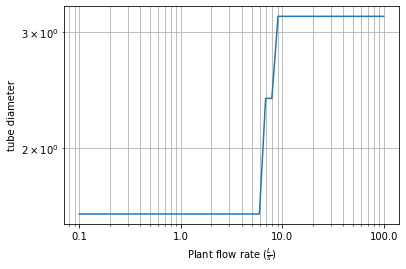

In [42]:
elements = 50
graphQ = np.logspace(-1,2,elements) * u.L/u.s
ID = np.array([2,3,4])* 1/32 * u.inch
IDa = np.empty(elements) * u.mm
tubeQa = np.empty(elements) * u.mL/u.s
na = np.empty(elements)
tubeLa = np.empty(elements) * u.cm
pacStockCa = np.empty(elements) * u.gram/u.L

for i in range(elements):
  tubeQa[i], na[i], IDa[i], tubeLa[i], pacStockCa[i] = dosingTubesStock(graphQ[i],pacDoseC,pacStockC_max,ID, HL, tubeL0, K,errorPI,chem)


plt.plot(graphQ,IDa)
plt.xscale("log")
plt.yscale("log")
# plt.legend(['Brownian','Interception','Gravity','Total'])
# plt.ylim(ymin=0.1,ymax=20)
# plt.xlim(xmin=0.1,xmax=50)
plt.grid(which='both',axis='both')
plt.ylabel('tube diameter')
plt.xlabel(r'Plant flow rate ($\frac{L}{s}$)')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.show()